# IRAT vs. Enet Comparison

**Note: this regenerates the final model using the `emergenet` package. The "Plots and Tables" sections makes plots from the original computation done in `final_irat_model/irat_predictions.ipynb`, which is used in the paper.**

For each IRAT strain (except `A/duck/New York/1996`, which does not have an HA available):
1. Look at all human strains within one year of IRAT assessment
2. For each HA subtype (in the HA column) with $\geq 15$ sequences:
    1. Construct an Enet with those HA sequences, including the IRAT strain (capped at 10k sequences)
    2. For all unique sequences, find the minimum E-distance between that sequence and the IRAT sequence under the Enet
3. Repeat step 2 for NA
4. Take the minimum E-distance across all subtypes for both HA and NA
5. Save results: `results/irat_predictions/irat.csv`

    
### Running Processes

Computations are done in:
- `irat_predictions.py`
- `run_irat_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_irat_predictions.sh`

`./run_irat_predictions.sh`

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, t, sem
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')
from emergenet.emergenet import predict_irat_emergence
from zedstat.textable import textable


RESULT_DIR = 'results/irat_predictions/'
OUT_DIR = 'tables/'

In [45]:
# IRAT, drop duck strain
irat = pd.read_csv('data/irat.csv')
irat = irat.drop(22).reset_index(drop=True)

ha_risks = []
na_risks = []
for i in range(len(irat)):
    row = irat.iloc[i]
    virus_name = row['Influenza Virus'].replace('/',':')
    DIR = RESULT_DIR + virus_name + '/results/'
    ha_risk = pd.read_csv(DIR + 'HA_min_risks.csv').min(axis=1).values[0] + 1e-5
    na_risk = pd.read_csv(DIR + 'NA_min_risks.csv').min(axis=1).values[0] + 1e-5
    ha_risks.append(ha_risk)
    na_risks.append(na_risk)
    
# Add to IRAT
irat['HA Risk'] = ha_risks
irat['NA Risk'] = na_risks
irat['Geom Mean Risk'] = np.sqrt(irat['HA Risk'] * irat['NA Risk'])
irat[['Predicted Emergence', 'Predicted Emergence Low', 'Predicted Emergence High']] = irat.apply(lambda row: predict_irat_emergence(row['HA Risk'], row['NA Risk']), axis=1, result_type='expand')
irat = irat.sort_values(by='Geom Mean Risk').reset_index(drop=True)
irat.to_csv(RESULT_DIR + 'irat.csv', index=False)
irat.drop(columns=['HA Sequence', 'NA Sequence', 'HA Length', 'NA Length', 'HA Risk', 'NA Risk']).round(5)

,Influenza Virus,Virus Type,Date of Risk Assessment,Risk Score Category,Emergence Score,Impact Score,Mean Low Acceptable Emergence,Mean High Acceptable Emergence,Mean Low Acceptable Impact,Mean High Acceptable Impact,Geom Mean Risk,Predicted Emergence,Predicted Emergence Low,Predicted Emergence High
0,A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,7.5,5.65,7.51,6.74,8.50,0.00001,7.73275,6.18766,9.17912
1,A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,7.2,5.52,7.43,6.41,8.32,0.00001,7.73275,6.18766,9.17912
2,A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,5.7,4.22,7.16,3.80,7.09,0.00001,7.73275,6.18766,9.17912
3,A/Indiana/08/2011,H3N2,2012-12-01,Moderate,6.0,4.5,-1.00,-1.00,-1.00,-1.00,0.00007,7.63644,6.10486,9.07354
4,A/Sichuan/06681/2021,H5N6,2021-10-01,Moderate,5.3,6.3,3.88,6.45,5.04,7.47,0.00139,6.52992,5.15347,7.86036
5,A/mink/Spain/3691-8_22VIR10586-10/2022,H5N1,2023-04-01,Moderate,5.1,6.2,3.96,6.27,4.95,7.43,0.00153,6.46614,5.09863,7.79043
6,A/Anhui-Lujiang/39/2018,H9N2,2019-07-01,Moderate,6.2,5.9,4.76,7.57,4.30,7.30,0.00192,6.30493,4.96002,7.61368
7,A/Ohio/13/2017,H3N2,2019-07-01,Moderate,6.6,5.8,5.01,7.59,4.09,7.26,0.00236,6.15214,4.82865,7.44615
8,A/swine/Shandong/1207/2016,H1N1,2020-07-01,Moderate,7.5,6.9,6.33,8.65,5.42,8.09,0.00527,5.50811,4.27490,6.74005
9,A/canine/Illinois/12191/2015,H3N2,2016-06-01,Low,3.7,3.7,2.81,4.90,2.69,4.90,0.00655,5.32508,4.11754,6.53938


## Plots and Tables
Use original model data in `final_irat_model/irat_predictions.ipynb`.

In [25]:
# IRAT from final model
irat = pd.read_csv('final_irat_model/results/irat.csv')
irat[['Predicted Emergence', 'Predicted Emergence Low', 'Predicted Emergence High']] = irat.apply(lambda row: predict_irat_emergence(row['HA Risk'], row['NA Risk']), axis=1, result_type='expand')
irat = irat.sort_values(by='Geom Mean Risk').reset_index(drop=True)
irat.to_csv(OUT_DIR + 'irat.csv', index=False)
# Round
irat = irat.drop(columns=['HA Sequence', 'NA Sequence', 'HA Length', 'NA Length', 'HA Risk', 'NA Risk', 'Impact Score', 'Mean Low Acceptable Impact', 'Mean High Acceptable Impact']).round(5)
columns_to_round = ['Predicted Emergence', 'Predicted Emergence Low', 'Predicted Emergence High']
irat[columns_to_round] = irat[columns_to_round].round(2)
irat = irat.set_index('Influenza Virus')
textable(irat, tabname = OUT_DIR + 'irat.tex', FORMAT='%1.5f')
irat

,Virus Type,Date of Risk Assessment,Risk Score Category,Emergence Score,Mean Low Acceptable Emergence,Mean High Acceptable Emergence,Geom Mean Risk,Predicted Emergence,Predicted Emergence Low,Predicted Emergence High
Influenza Virus,,,,,,,,,,
A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,5.65,7.51,0.00001,7.73,6.19,9.18
A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,5.52,7.43,0.00001,7.73,6.19,9.18
A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,4.22,7.16,0.00001,7.73,6.19,9.18
A/Indiana/08/2011,H3N2,2012-12-01,Moderate,6.0,-1.00,-1.00,0.00005,7.67,6.13,9.11
A/Sichuan/06681/2021,H5N6,2021-10-01,Moderate,5.3,3.88,6.45,0.00128,6.58,5.20,7.92
A/Anhui-Lujiang/39/2018,H9N2,2019-07-01,Moderate,6.2,4.76,7.57,0.00163,6.42,5.06,7.74
A/Ohio/13/2017,H3N2,2019-07-01,Moderate,6.6,5.01,7.59,0.00200,6.27,4.93,7.58
A/mink/Spain/3691-8_22VIR10586-10/2022,H5N1,2023-04-01,Moderate,5.1,3.96,6.27,0.00264,6.06,4.75,7.35
A/swine/Shandong/1207/2016,H1N1,2020-07-01,Moderate,7.5,6.33,8.65,0.00315,5.93,4.64,7.20


In [4]:
def TLS(X, Y):
    A = np.vstack([X, Y]).T
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    A_centered = A - np.array([mean_X, mean_Y])
    U, S, Vt = np.linalg.svd(A_centered, full_matrices=False)
    tls_direction = Vt[0, :]
    tls_slope = tls_direction[1] / tls_direction[0]
    tls_intercept = mean_Y - (tls_direction[1] / tls_direction[0]) * mean_X
    tls_Y_pred = tls_slope * X + tls_intercept
    tls_R, _ = pearsonr(tls_Y_pred, Y)
    # p-values
    n = len(X)
    df = n - 2
    t_statistic = tls_R * np.sqrt(df / (1 - tls_R**2))
    tls_p = 2 * (1 - t.cdf(abs(t_statistic), df=df))
    return tls_slope, tls_intercept, tls_R, tls_p

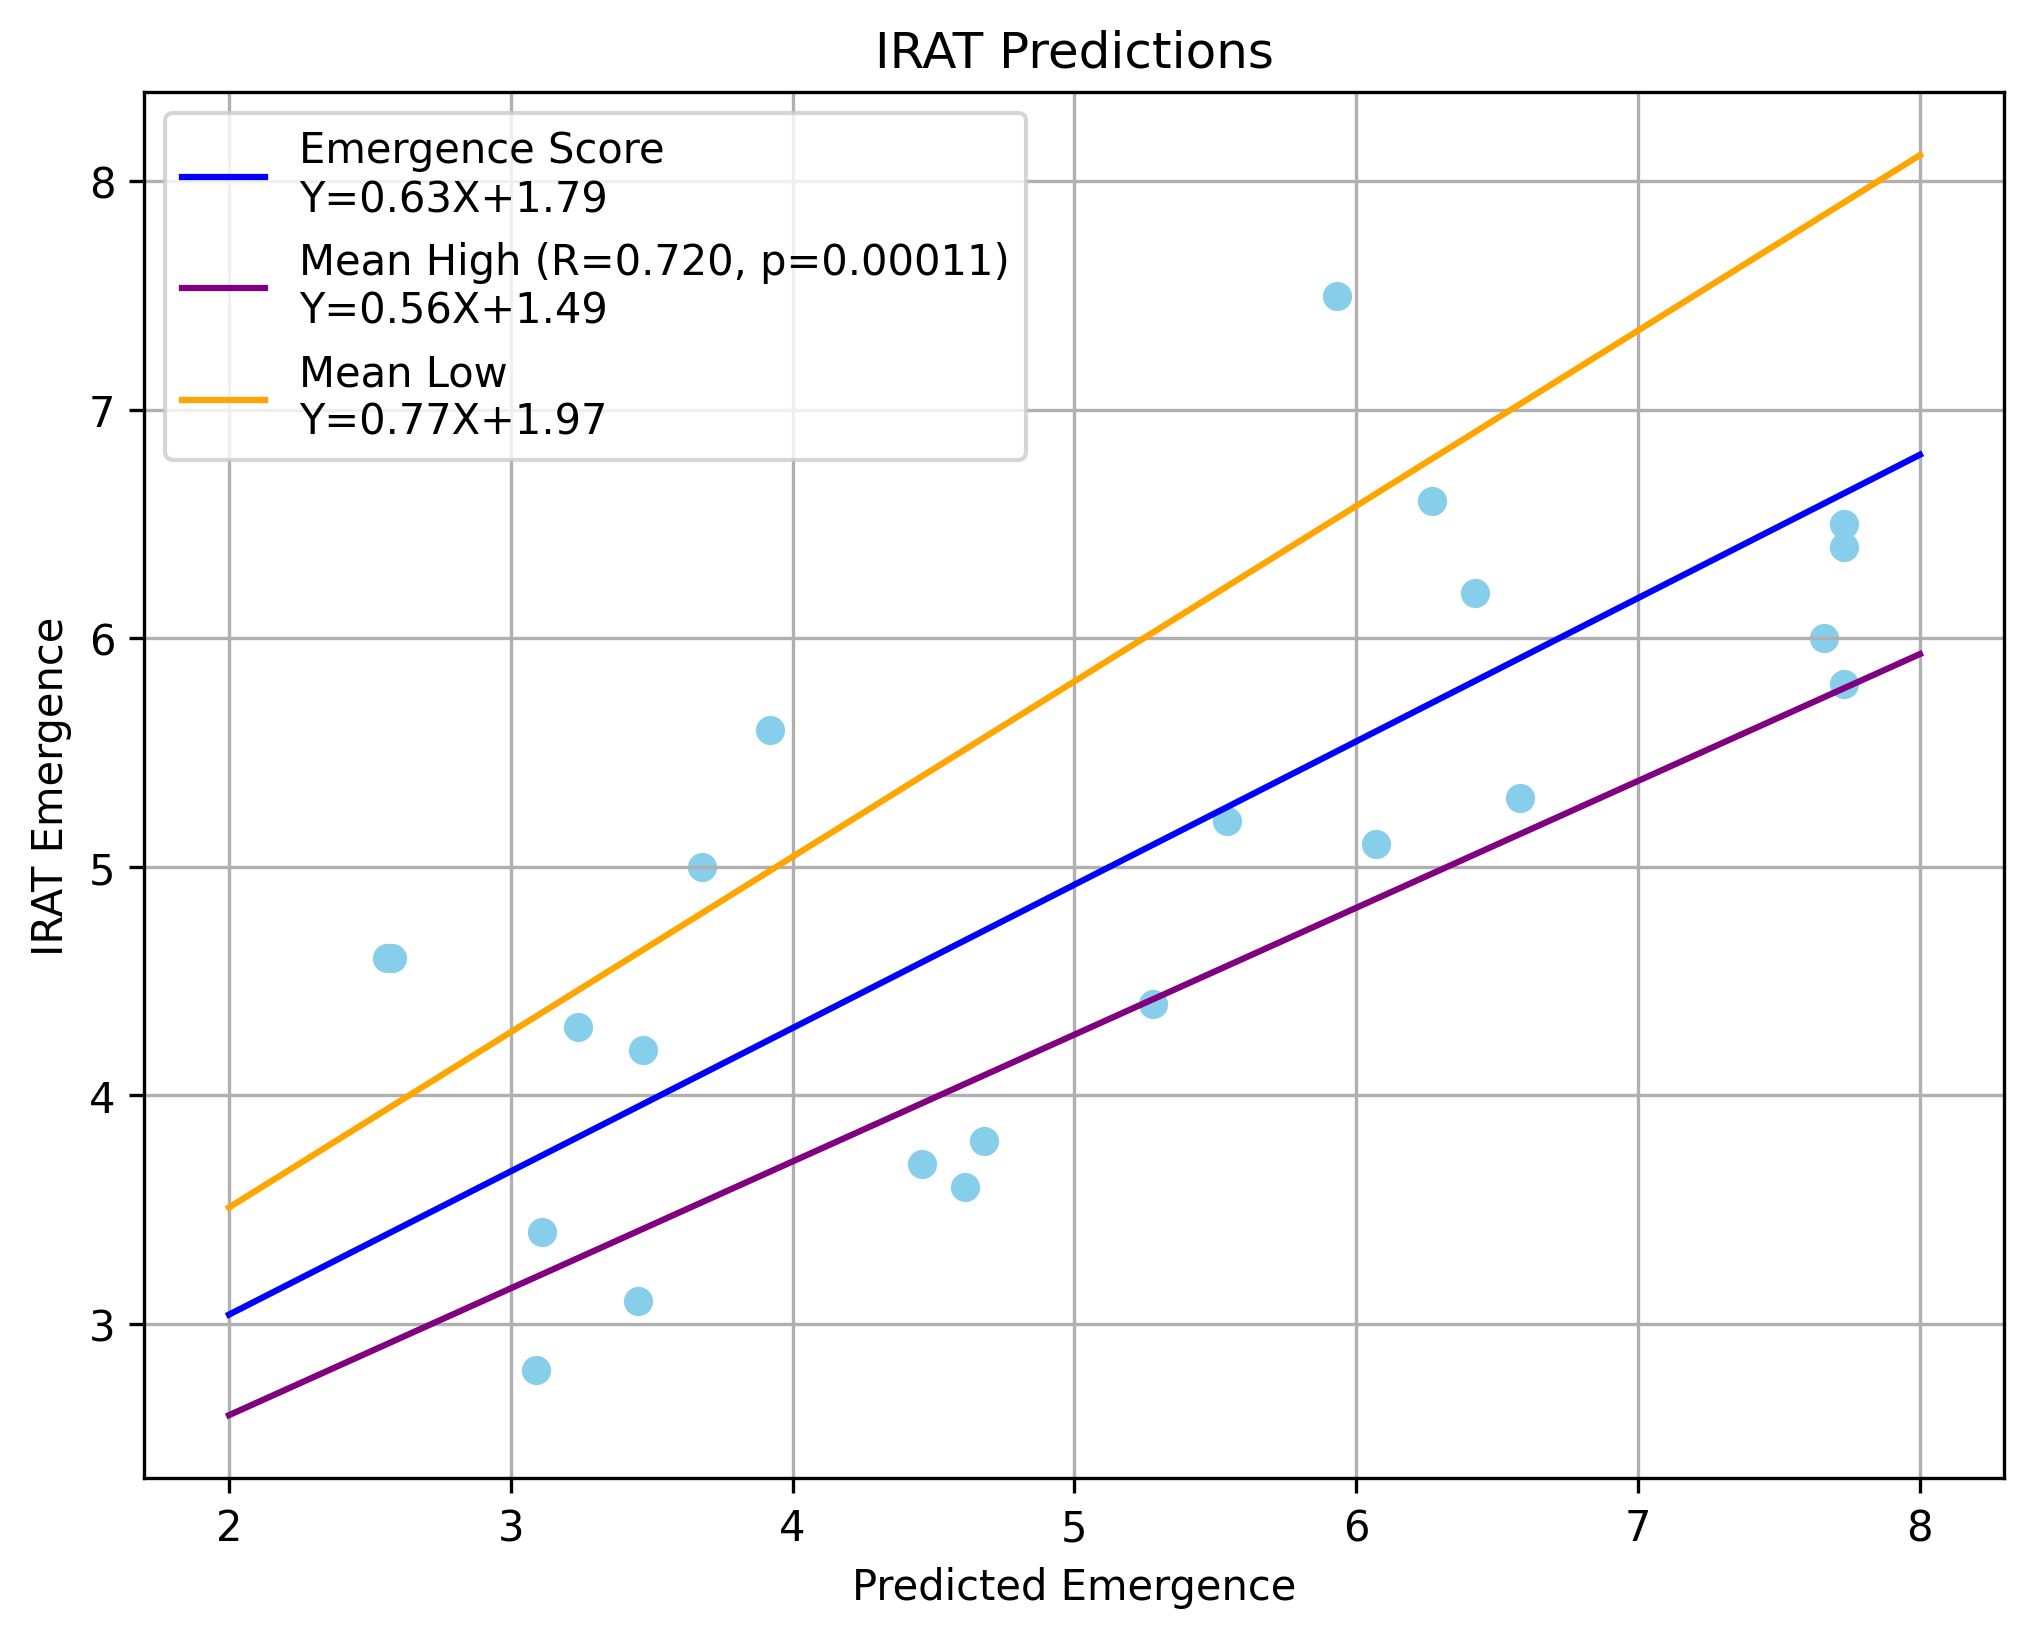

In [7]:
const = 5e-4

# IRAT emergence
X = irat['Predicted Emergence']
Y = irat['Emergence Score']
tls_slope, tls_intercept, tls_R, _ = TLS(X, Y)
X_line = np.linspace(2, 8, 100)
Y_tls = tls_slope * X_line + tls_intercept
plt.scatter(X, Y, color='skyblue')
plt.plot(X_line, Y_tls, label=f'Emergence Score\nY={tls_slope:.2f}X+{tls_intercept:.2f}', color='blue')

# Mean high emergence
X = irat['Predicted Emergence High']
Y = irat['Emergence Score']
tls_slope, tls_intercept, tls_R, tls_p = TLS(X, Y)
Y_tls = tls_slope * X_line + tls_intercept
plt.plot(X_line, Y_tls, label=f'Mean High (R={tls_R:.3f}, p={tls_p:.5f})\nY={tls_slope:.2f}X+{tls_intercept:.2f}', color='purple')

# Mean low emergence
X = irat['Predicted Emergence Low']
Y = irat['Emergence Score']
tls_slope, tls_intercept, tls_R, _ = TLS(X, Y)
Y_tls = tls_slope * X_line + tls_intercept
plt.plot(X_line, Y_tls, label=f'Mean Low\nY={tls_slope:.2f}X+{tls_intercept:.2f}', color='orange')


plt.xlabel('Predicted Emergence')
plt.ylabel('IRAT Emergence')
plt.legend()
plt.grid()
plt.title('IRAT Predictions');

## Sampling Effects

We explore sampling effects. We randomly sample 75% of the strain population for Enet training and risk evaluation, computing the mean and standard error over 20 random seeds.

### Running Processes

Computations are done in:
- `irat_predictions_sem.py`
- `run_irat_predictions_sem.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_irat_predictions_sem.sh`

`./run_irat_predictions_sem.sh`

In [46]:
# IRAT, drop duck strain
irat = pd.read_csv('data/irat.csv')
irat = irat.drop([22]).reset_index(drop=True)
n = 20

ha_risks = []
ha_risks_sem = []
na_risks = []
na_risks_sem = []
geom_mean_risks = []
geom_mean_risks_sem = []
predicted_emergence = []
predicted_emergence_sem = []
predicted_emergence_low = []
predicted_emergence_low_sem = []
predicted_emergence_high = []
predicted_emergence_high_sem = []
for i in range(len(irat)):
    row = irat.iloc[i]
    virus_name = row['Influenza Virus'].replace('/',':')
    DIR = RESULT_DIR + virus_name + '/sem/'
    cur_ha_risks = []
    cur_na_risks = []
    for i in range(n):
        SUBDIR = DIR + str(i) + '/results/'
        ha_risk = pd.read_csv(SUBDIR + 'HA_min_risks.csv').min(axis=1).values[0] + 1e-5
        na_risk = pd.read_csv(SUBDIR + 'NA_min_risks.csv').min(axis=1).values[0] + 1e-5
        cur_ha_risks.append(ha_risk)
        cur_na_risks.append(na_risk)
    cur_ha_risks = np.array(cur_ha_risks)
    cur_na_risks = np.array(cur_na_risks)
    
    ha_risks.append(np.mean(cur_ha_risks))
    ha_risks_sem.append(sem(cur_ha_risks))
    na_risks.append(np.mean(cur_na_risks))
    na_risks_sem.append(sem(cur_na_risks))
    geom_mean_risks.append(np.mean(np.sqrt(cur_ha_risks * cur_na_risks)))
    geom_mean_risks_sem.append(sem(np.sqrt(cur_ha_risks * cur_na_risks)))
    predicted_emergence.append(np.mean([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[0] for j in range(n)]))
    predicted_emergence_sem.append(sem([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[0] for j in range(n)]))
    predicted_emergence_low.append(np.mean([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[1] for j in range(n)]))
    predicted_emergence_low_sem.append(sem([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[1] for j in range(n)]))
    predicted_emergence_high.append(np.mean([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[2] for j in range(n)]))
    predicted_emergence_high_sem.append(sem([predict_irat_emergence(cur_ha_risks[j], cur_na_risks[j])[2] for j in range(n)]))
    
    
# Add to IRAT
irat['HA Risk'] = ha_risks
irat['HA Risk SEM'] = ha_risks_sem
irat['NA Risk'] = na_risks
irat['NA Risk SEM'] = na_risks_sem
irat['Geom Mean Risk'] = geom_mean_risks
irat['Geom Mean Risk SEM'] = geom_mean_risks_sem
irat['Predicted Emergence'] = predicted_emergence
irat['Predicted Emergence SEM'] = predicted_emergence_sem
irat['Predicted Emergence Low'] = predicted_emergence_low
irat['Predicted Emergence Low SEM'] = predicted_emergence_low_sem
irat['Predicted Emergence High'] = predicted_emergence_high
irat['Predicted Emergence High SEM'] = predicted_emergence_high_sem
irat = irat.sort_values(by='Geom Mean Risk').reset_index(drop=True)
irat.to_csv(RESULT_DIR + 'irat_sem.csv', index=False)

In [47]:
irat = pd.read_csv(RESULT_DIR + 'irat_sem.csv')
irat = irat.drop(columns=['Impact Score',
                          'Mean Low Acceptable Impact',
                          'Mean High Acceptable Impact',
                          'Mean Low Acceptable Emergence',
                          'Mean High Acceptable Emergence',
                          'HA Sequence',
                          'NA Sequence',
                          'HA Length',
                          'NA Length',
                          'HA Risk',
                          'HA Risk SEM',
                          'NA Risk',
                          'NA Risk SEM',
                          'Predicted Emergence Low',
                          'Predicted Emergence Low SEM',
                          'Predicted Emergence High',
                          'Predicted Emergence High SEM']).round(5)
irat['Predicted Emergence'] = irat['Predicted Emergence'].round(2)
irat['Predicted Emergence SEM'] = irat['Predicted Emergence SEM'].round(3)
irat1 = pd.read_csv(OUT_DIR + 'irat.csv')[['Influenza Virus', 'Predicted Emergence']].round(2)
irat1 = irat1.rename(columns={'Predicted Emergence':'Predicted Emergence W/O Sampling'})
irat = pd.merge(irat, irat1, on='Influenza Virus', how='inner')
irat = irat.set_index('Influenza Virus')
textable(irat, tabname = OUT_DIR + 'irat_sem.tex', FORMAT='%1.5f')
irat

,Virus Type,Date of Risk Assessment,Risk Score Category,Emergence Score,Geom Mean Risk,Geom Mean Risk SEM,Predicted Emergence,Predicted Emergence SEM,Predicted Emergence W/O Sampling
Influenza Virus,,,,,,,,,
A/Hong Kong/125/2017,H7N9,2017-05-01,Moderate-High,6.5,0.00001,0.00000,7.73,0.000,7.73
A/California/62/2018,H1N2,2019-07-01,Moderate,5.8,0.00001,0.00000,7.73,0.000,7.73
A/Shanghai/02/2013,H7N9,2016-04-01,Moderate-High,6.4,0.00002,0.00001,7.72,0.017,7.73
A/Indiana/08/2011,H3N2,2012-12-01,Moderate,6.0,0.00028,0.00007,7.40,0.066,7.67
A/Ohio/13/2017,H3N2,2019-07-01,Moderate,6.6,0.00227,0.00010,6.19,0.029,6.27
A/Anhui-Lujiang/39/2018,H9N2,2019-07-01,Moderate,6.2,0.00327,0.00029,5.95,0.069,6.42
A/swine/Shandong/1207/2016,H1N1,2020-07-01,Moderate,7.5,0.00366,0.00047,5.90,0.090,5.93
A/mink/Spain/3691-8_22VIR10586-10/2022,H5N1,2023-04-01,Moderate,5.1,0.00371,0.00059,5.99,0.141,6.06
A/canine/Illinois/12191/2015,H3N2,2016-06-01,Low,3.7,0.00854,0.00101,5.18,0.082,4.46
